In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def read_roc(dir_path: str):
    roc = {}
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        roc[target] = np.load(os.path.join(dir_path, 'ROC_{}.npy'.format(target)), allow_pickle=True)
    return roc

control_roc = read_roc('../output/control')
KNN_roc = read_roc('../output/data_fill/KNN')
rpca_roc = read_roc('../output/data_fill/rpca')

In [3]:
def lineplot(data, x=None, y=None, hue=None, xticklabels=None, output_path: str = None, figsize: tuple = (24, 12)):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.lineplot(data=data, x=x, y=y, hue=hue)
    ax = sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='red')

    plt.legend(loc='lower right')
    plt.grid(False)

    if x:
        plt.xlabel(x)
    if y:
        plt.ylabel(y)
    if xticklabels:
        ax.set_xticklabels(labels=xticklabels)

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()

In [4]:
def plot(roc, output_dir=None):
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        methods_result = roc[target].item()

        _rocs = pd.DataFrame()
        for method_name in methods_result.keys():
            _xs, _ys = methods_result[method_name][0], methods_result[method_name][1]

            tprs = []
            mean_fpr = np.linspace(0, 1, 100)
            for i in range(len(_xs)):
                _x, _y = _xs[i], _ys[i]
                interp_tpr = np.interp(mean_fpr, _x, _y)
                interp_tpr[0], interp_tpr[-1] = 0.0, 1
                _tprs = interp_tpr.tolist()
                tprs.extend(_tprs)

            _df = pd.DataFrame({
                'FPR': mean_fpr.tolist() * len(_xs), 'TPR': tprs,
                'method': '{}(AUC={})'.format(method_name, round(np.mean(methods_result[method_name][2]), 2))
            })
            _rocs = pd.concat([_rocs, _df])
        _rocs.reset_index(drop=True, inplace=True)

        lineplot(
            _rocs,
            x='FPR',
            y='TPR',
            hue='method',
            output_path='{}/ROC({}).pdf'.format(output_dir, target) if output_dir else None,
            figsize=(8, 8)
        )

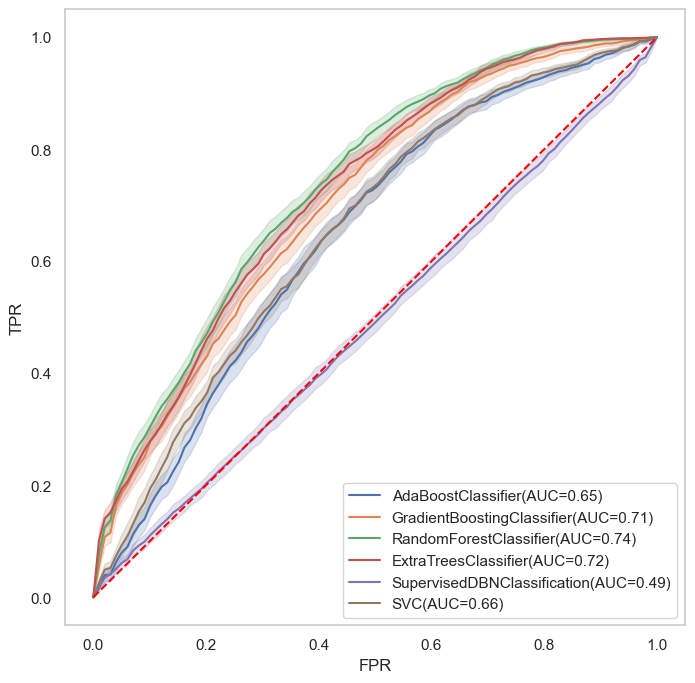

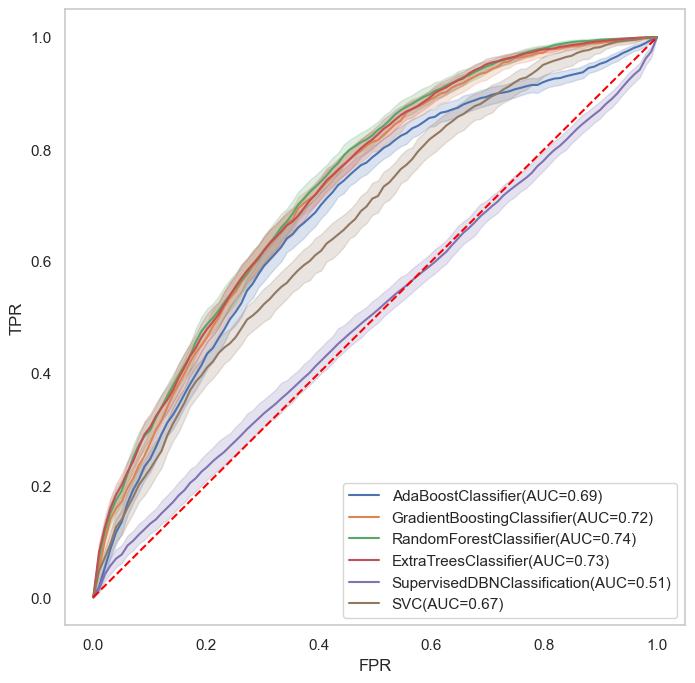

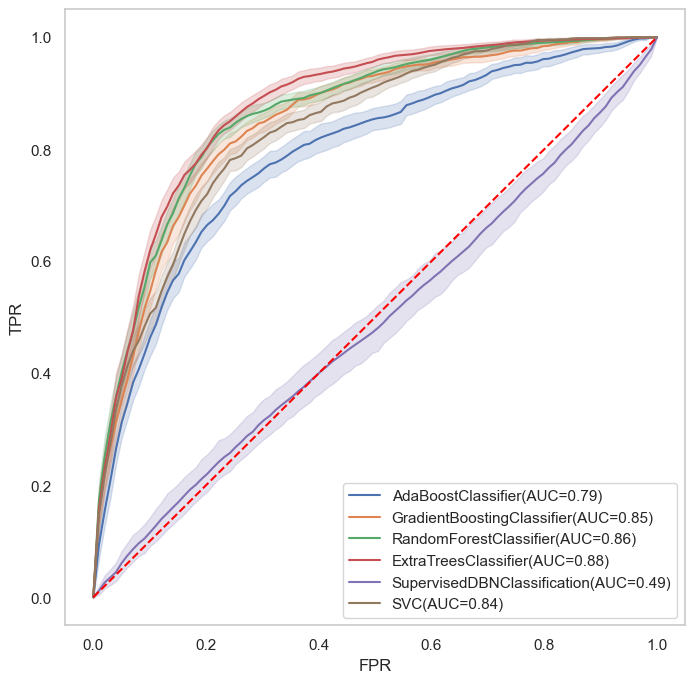

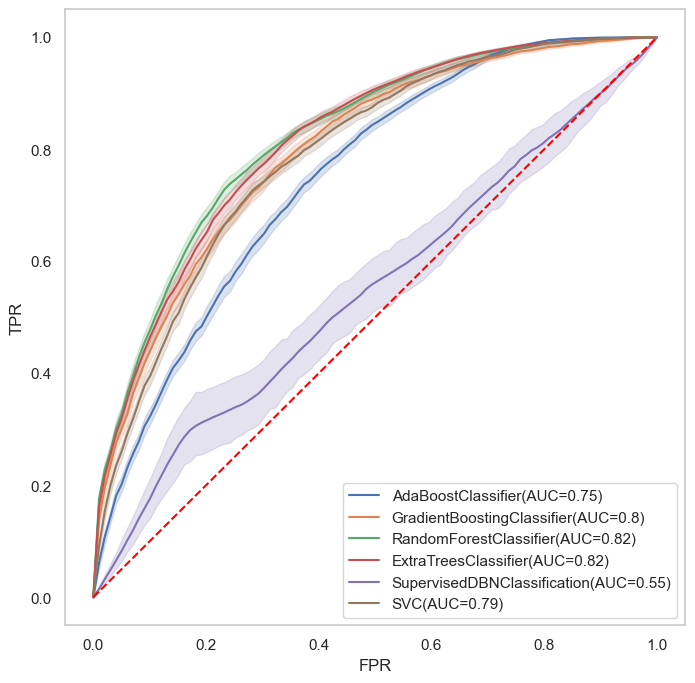

In [5]:
plot(control_roc, '../output/control')

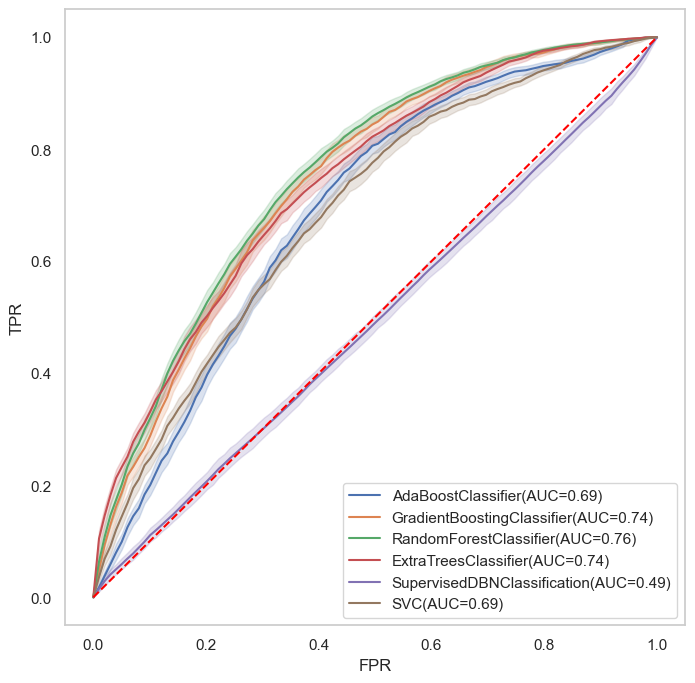

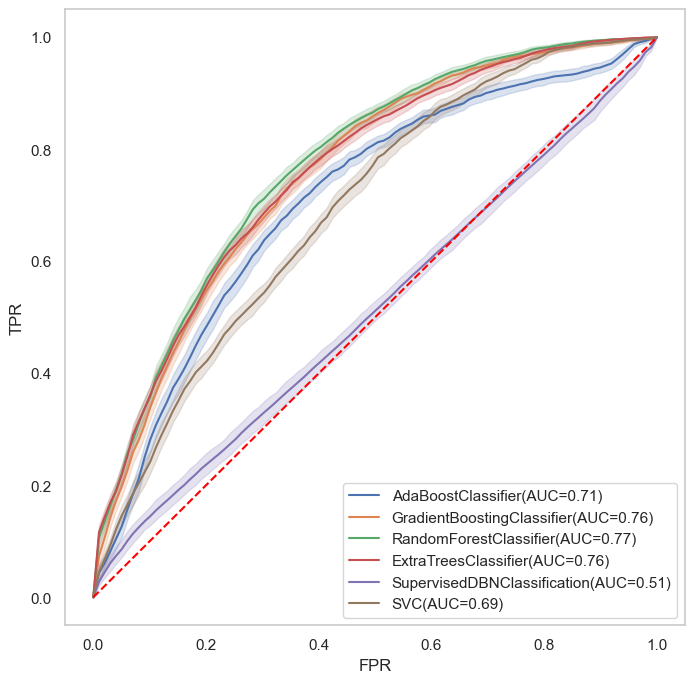

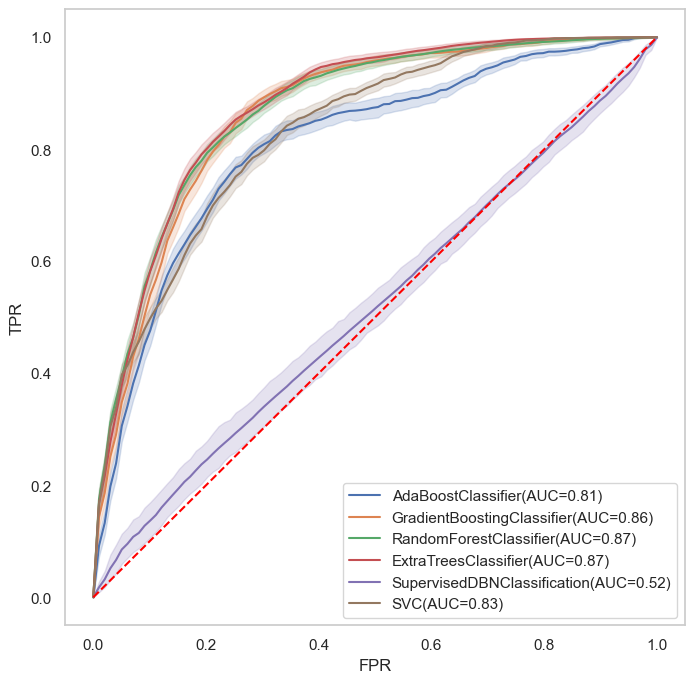

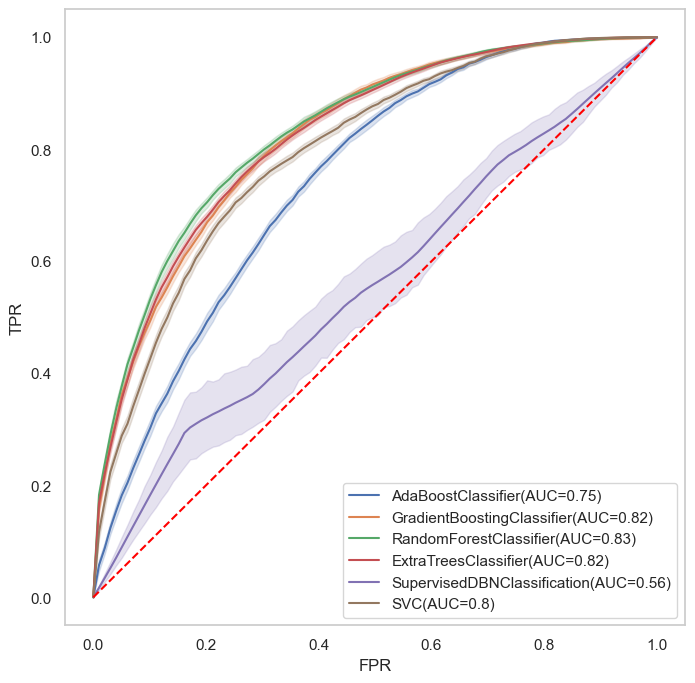

In [6]:
plot(KNN_roc, '../output/data_fill/KNN')

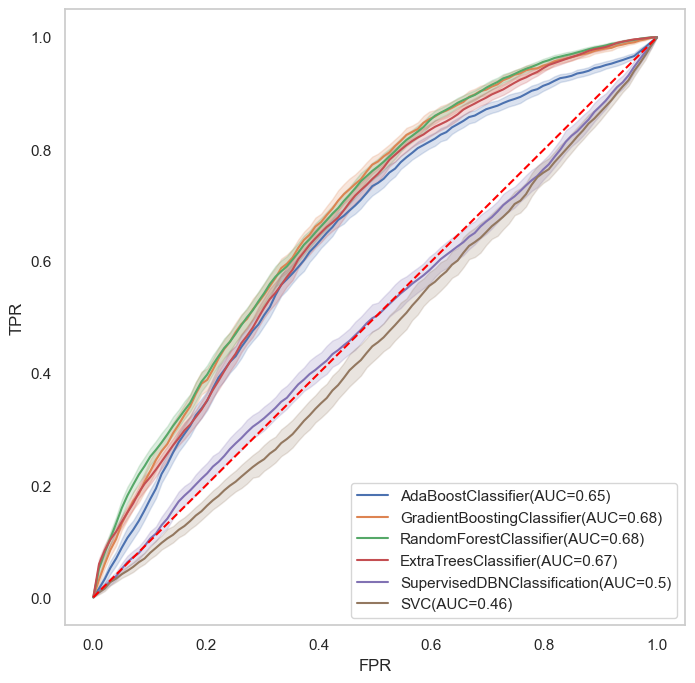

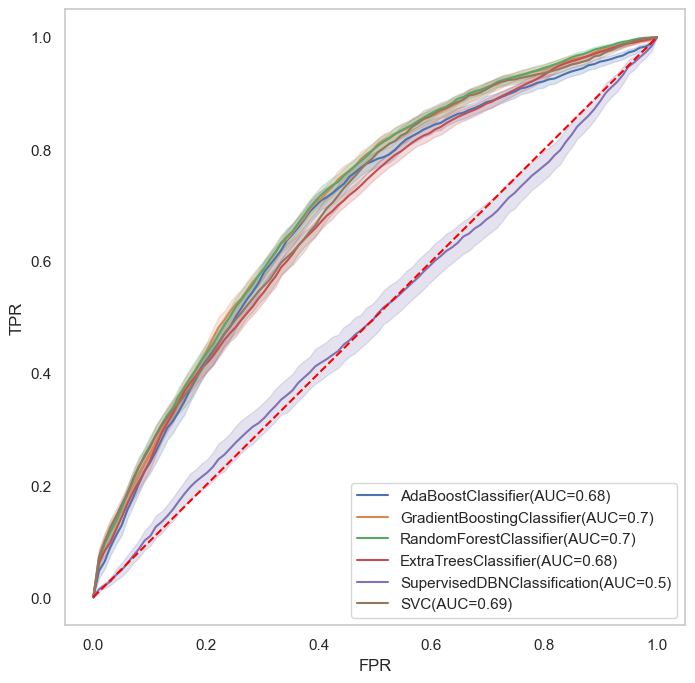

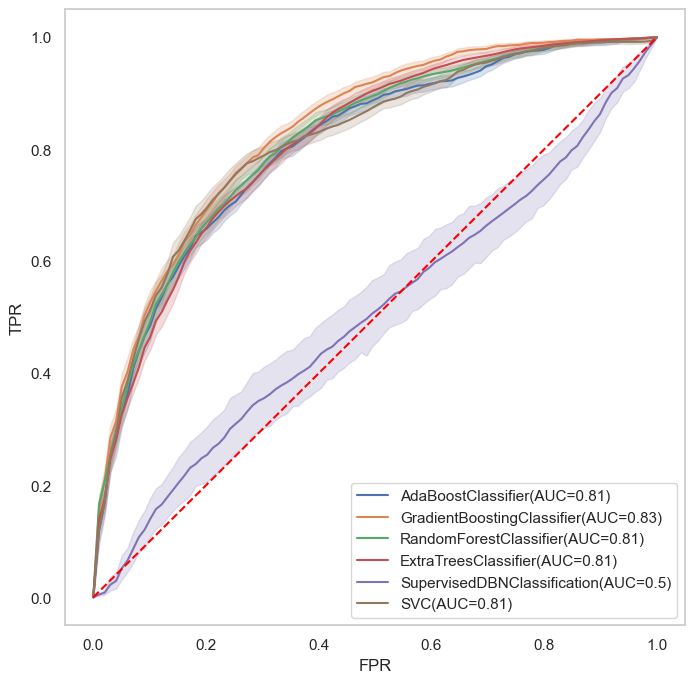

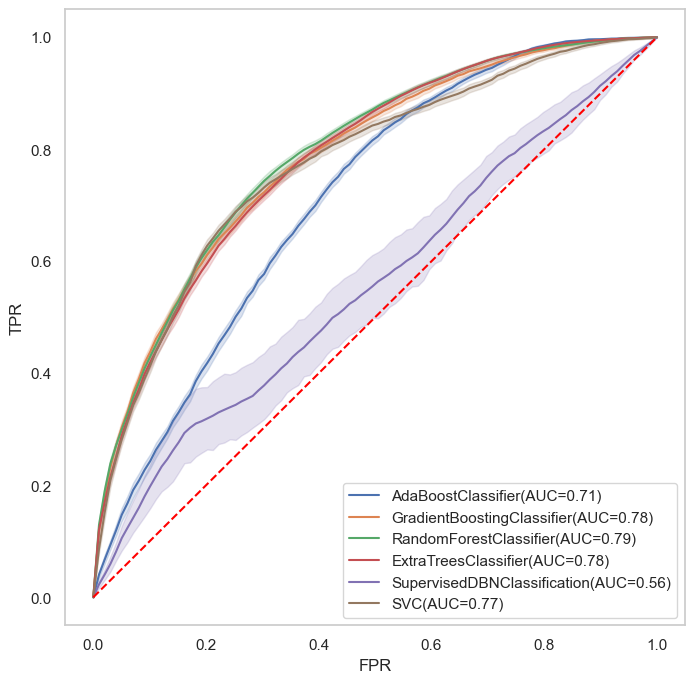

In [7]:
plot(rpca_roc, '../output/data_fill/rpca')

In [8]:
def read_accuracy(dir_path: str):
    acc = {}
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        acc[target] = pd.read_csv(os.path.join(dir_path, 'accuracy_{}.csv'.format(target)), index_col=0)
    return acc

control_acc = read_accuracy('../output/control')
KNN_acc = read_accuracy('../output/data_fill/KNN')
rpca_acc = read_accuracy('../output/data_fill/rpca')

In [9]:
def get_comprehensive_comparison(acc, roc):
    acc_result = pd.DataFrame()
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        _acc = pd.DataFrame(acc[target].mean(), columns=[target])
        _acc = (round(_acc * 100, 2)).astype(str)
        _acc[target] += '±' + (round(acc[target].std() * 100, 2)).astype(str)
        acc_result = pd.concat([acc_result, _acc], axis=1)
    acc_result.columns = pd.MultiIndex.from_product([['Accuracy(%)'], acc_result.columns])

    roc_auc_result = pd.DataFrame()
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        _roc = roc[target].item()
        _roc_auc = [
            roc[target].item()[key][2]
            for key in _roc.keys()
        ]
        _roc_auc = pd.DataFrame(_roc_auc, index=_roc.keys())
        _auc = pd.DataFrame(_roc_auc.mean(axis=1), columns=[target])
        _auc = (round(_auc, 2)).astype(str)
        _auc[target] += '±' + (round(_roc_auc.std(axis=1), 2)).astype(str)
        roc_auc_result = pd.concat([roc_auc_result, _auc], axis=1)
    roc_auc_result.columns = pd.MultiIndex.from_product([['ROC-AUC'], roc_auc_result.columns])

    comprehensive_result = pd.concat([acc_result, roc_auc_result], axis=1)
    return comprehensive_result

In [10]:
comprehensive_result = get_comprehensive_comparison(control_acc, control_roc)
comprehensive_result.to_csv('../output/control/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                 \
                              effective markedly effective       cured   
AdaBoostClassifier           61.68±4.47          65.9±3.68   79.9±3.22   
GradientBoostingClassifier   64.29±4.04         66.61±4.24  81.94±2.64   
RandomForestClassifier        66.7±3.14         67.34±3.74   82.8±2.81   
ExtraTreesClassifier         65.98±3.23         67.38±3.76   83.34±3.0   
SupervisedDBNClassification  47.52±3.19         61.47±3.43   78.1±2.94   
SVC                          58.24±4.76         61.44±3.41   78.1±2.94   

                                           ROC-AUC                     \
                                    all  effective markedly effective   
AdaBoostClassifier           46.98±5.92  0.65±0.05          0.69±0.05   
GradientBoostingClassifier   53.94±4.26  0.71±0.04          0.72±0.05   
RandomForestClassifier       56.83±4.31  0.74±0.04          0.74±0.04   
ExtraTreesClassifier         55.23±4.19  0.72±0.03          0.73±0.04   
SupervisedDBNClassification  48.62±3.83  0.49±0.04          0.51±0.06   
SVC                           48.1±3.69  0.66±0.04          0.67±0.07   

                                                   
                                 cured        all  
AdaBoostClassifier           0.79±0.05  0.75±0.03  
GradientBoostingClassifier   0.85±0.04   0.8±0.03  
RandomForestClassifier       0.86±0.03  0.82±0.02  
ExtraTreesClassifier         0.88±0.03  0.82±0.02  
SupervisedDBNClassification   0.49±0.1  0.55±0.13  
SVC                          0.84±0.04  0.79±0.02

In [11]:
comprehensive_result = get_comprehensive_comparison(KNN_acc, KNN_roc)
comprehensive_result.to_csv('../output/data_fill/KNN/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                 \
                              effective markedly effective       cured   
AdaBoostClassifier           64.79±3.18         68.38±3.23  80.74±2.97   
GradientBoostingClassifier   68.54±2.44         70.64±2.36  82.23±2.14   
RandomForestClassifier       69.06±3.06         70.89±2.74  82.78±2.12   
ExtraTreesClassifier          67.16±3.1         70.84±2.18  83.06±2.15   
SupervisedDBNClassification  48.49±2.03         63.24±2.46  78.96±2.58   
SVC                          61.89±3.55         63.24±2.46  78.96±2.58   

                                           ROC-AUC                     \
                                    all  effective markedly effective   
AdaBoostClassifier           47.67±3.92  0.69±0.03          0.71±0.04   
GradientBoostingClassifier    57.14±2.7  0.74±0.03          0.76±0.03   
RandomForestClassifier       59.47±3.12  0.76±0.03          0.77±0.02   
ExtraTreesClassifier         57.67±2.67  0.74±0.03          0.76±0.02   
SupervisedDBNClassification  50.56±2.47  0.49±0.04          0.51±0.06   
SVC                          50.16±2.33  0.69±0.03          0.69±0.03   

                                                   
                                 cured        all  
AdaBoostClassifier           0.81±0.04  0.75±0.02  
GradientBoostingClassifier   0.86±0.03  0.82±0.02  
RandomForestClassifier       0.87±0.02  0.83±0.02  
ExtraTreesClassifier         0.87±0.02  0.82±0.01  
SupervisedDBNClassification  0.52±0.09  0.56±0.13  
SVC                          0.83±0.03   0.8±0.02